렌터카 플렛폼 업체에서 데이터를 다루며 가장 필요한 데이터는 미래 수요, 관광객이 얼마나 올지에 대한 예측 데이터였다.

평소 여행을 좋아했기 때문에, 먼저 스스로 어떤 과정을 통해 여행을 결심하고 실행에 옮기는지 고민했다.

1. 시간
2. 예산
3. 여행지
4. 티켓 구매
5. 여행 계획

이 과정에서, 데이터로 추출할 수 있는 명확한 지표는 4.티켓이라 판단하였다.

따라서 매일 항공권 데이터를 수집한다면 데이터의 가격, 좌석수 등 항공권의 일변량을 감지할 수 있고, 이 변화를 활용하여 수요 예측 모델을 만들고자 한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import warnings
from tqdm import tqdm, trange

pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore', FutureWarning)

# Dataset

In [29]:
dataset.groupby(["AIRLINE", "CLASS_CODE"]).count()[:30]

DEPART_DATE  DEPART_TIME  FLIGHT_NO  DEPART  ARRIVE  \
AIRLINE CLASS_CODE                                                        
7C      A                     0            0          0       0       0   
        A1                    0            0          0       0       0   
        A2                    0            0          0       0       0   
        A3                    0            0          0       0       0   
        A4                    0            0          0       0       0   
        A5                    0            0          0       0       0   
        B                 12711        12711      12711   12711   12711   
        B1                    0            0          0       0       0   
        B2                    0            0          0       0       0   
        BB                    0            0          0       0       0   
        C                 17128        17128      17128   17128   17128   
        C1                    0            0          0       0       0   
        C2                    0            0          0       0       0   
        C3                    0            0          0       0       0   
        C4                    0            0          0       0       0   
        C5                    0            0          0       0       0   
        D                 30005        30005      30005   30005   30005   
        E                 30144        30144      30144   30144   30144   
        E1                    0            0          0       0       0   
        E2                    0            0          0       0       0   
        E3                    0            0          0       0       0   
        E4                    0            0          0       0       0   
        F                 23975        23975      23975   23975   23975   
        F0                    0            0          0       0       0   
        F2                    0            0          0       0       0   
        F4                    0            0          0       0       0   
        F6                    0            0          0       0       0   
        F8                    0            0          0       0       0   
        G                 17979        17979      17979   17979   17979   
        H                 28066        28066      28066   28066   28066   

                    CLASS_DESC  AVAIL_SEAT   FARE  SEARCH_DATE  SEARCH_TIME  \
AIRLINE CLASS_CODE                                                            
7C      A                    0           0      0            0            0   
        A1                   0           0      0            0            0   
        A2                   0           0      0            0            0   
        A3                   0           0      0            0            0   
        A4                   0           0      0            0            0   
        A5                   0           0      0            0            0   
        B                12711       12711  12711        12711        12711   
        B1                   0           0      0            0            0   
        B2                   0           0      0            0            0   
        BB                   0           0      0            0            0   
        C                17128       17128  17128        17128        17128   
        C1                   0           0      0            0            0   
        C2                   0           0      0            0            0   
        C3                   0           0      0            0            0   
        C4                   0           0      0            0            0   
        C5                   0           0      0            0            0   
        D                30005       30005  30005        30005        30005   
        E                30144       30144  30144        30144        30144   
        E1                   0         

In [2]:
## 항공권 티켓
dataset = pd.read_csv("./data/AIRLINE_TICKET_2022.csv", encoding = 'cp949')

## 공휴일 정보
holiday_2022 = pd.read_csv("./data/HOLIDAY_2022.csv", encoding = 'UTF-8-SIG')

## 에어포탈 정보
airportal_cju_2022 = pd.read_csv("./data/AIRPORTAL_CJU_2022.csv", encoding = 'UTF-8-SIG')
airportal = airportal_cju_2022[["DT", "IATA_DEPART", "IATA_ARRIVE", "IATA", "AIR_ARRIVE", "PSG_ARRIVE"]]
airportal = airportal.replace(" ", "")
airportal = airportal.query("IATA_ARRIVE == 'CJU'")
airportal = airportal.groupby(["DT"], as_index = False).sum()

## 기상청 정보
weather_total_2022 = pd.read_csv("./data/WEATHER_TOTAL_2022.csv", encoding = 'UTF-8-SIG')
weather_air_2022 = pd.read_csv("./data/WEATHER_2022.csv", encoding = 'UTF-8-SIG')
weather_2022 = pd.merge(weather_total_2022, weather_air_2022, left_on = "tm", right_on = "tmFc", how = "left")

display(dataset, holiday_2022, airportal, weather_2022)

,DEPART_DATE,DEPART_TIME,AIRLINE,FLIGHT_NO,DEPART,ARRIVE,CLASS_CODE,CLASS_DESC,AVAIL_SEAT,FARE_ORIGIN,FARE,SEARCH_DATE,SEARCH_TIME
0,2022-01-02 00:00:00.000,600,7C,163,GMP,CJU,Y,일반석,9,85000.0,85000,2022-01-01 00:00:00.000,926
1,2022-01-02 00:00:00.000,600,7C,163,GMP,CJU,J,특가석,9,4000.0,4000,2022-01-01 00:00:00.000,926
2,2022-01-02 00:00:00.000,605,OZ,8901,GMP,CJU,Y,일반석,9,103000.0,103000,2022-01-01 00:00:00.000,926
3,2022-01-02 00:00:00.000,605,OZ,8901,GMP,CJU,O,특가석,9,12000.0,12000,2022-01-01 00:00:00.000,926
4,2022-01-02 00:00:00.000,605,LJ,423,GMP,CJU,Z0,특가석,9,4000.0,4000,2022-01-01 00:00:00.000,926
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8274164,2023-01-20 00:00:00.000,940,LJ,307,GMP,CJU,Y,일반석,2,107000.0,107000,2022-12-31 00:00:00.000,602
8274165,2023-01-20 00:00:00.000,1055,OZ,8927,GMP,CJU,Y,일반석,1,120000.0,120000,2022-12-31 00:00:00.000,602
8274166,2023-01-20 00:00:00.000,1135,OZ,8935,GMP,CJU,Y,일반석,1,120000.0,120000,2022-12-31 00:00:00.000,602
8274167,2023-01-20 00:00:00.000,1145,KE,1091,GMP,CJU,Y,일반석,1,136400.0,117000,2022-12-31 00:00:00.000,602


,DT,DESC,HOLIDAY
0,2022-01-01,1월1일,Y
1,2022-01-31,설날,Y
2,2022-02-01,설날,Y
3,2022-02-02,설날,Y
4,2022-03-01,삼일절,Y
5,2022-03-09,대통령선거일,Y
6,2022-05-05,어린이날,Y
7,2022-05-08,부처님오신날,Y
8,2022-06-01,전국동시지방선거,Y
9,2022-06-06,현충일,Y


,DT,AIR_ARRIVE,PSG_ARRIVE
0,2022-01-01,229,29343
1,2022-01-02,242,35494
2,2022-01-03,227,37002
3,2022-01-04,221,35380
4,2022-01-05,219,36699
...,...,...,...
451,2023-03-28,220,37386
452,2023-03-29,228,38968
453,2023-03-30,226,40319
454,2023-03-31,220,41546


,stnId,stnNm,tm,avgTa,minTa,minTaHrmt,maxTa,maxTaHrmt,mi10MaxRn,mi10MaxRnHrmt,hr1MaxRn,hr1MaxRnHrmt,sumRnDur,sumRn,maxInsWs,maxInsWsWd,maxInsWsHrmt,maxWs,maxWsWd,maxWsHrmt,avgWs,hr24SumRws,maxWd,avgTd,minRhm,minRhmHrmt,avgRhm,avgPv,avgPa,maxPs,maxPsHrmt,minPs,minPsHrmt,avgPs,ssDur,sumSsHr,hr1MaxIcsrHrmt,hr1MaxIcsr,sumGsr,ddMefs,ddMefsHrmt,ddMes,ddMesHrmt,sumDpthFhsc,avgTca,avgLmac,avgTs,minTg,avgCm5Te,avgCm10Te,avgCm20Te,avgCm30Te,avgM05Te,avgM10Te,avgM15Te,avgM30Te,avgM50Te,sumLrgEv,sumSmlEv,n99Rn,iscs,sumFogDur,icaoCode,airportName,tmFc,wd,ws,ta,qnh
0,184,제주,2022-01-01,4.9,0.9,736,8.9,1345,NaN,NaN,NaN,NaN,NaN,NaN,7.9,20,6,4.4,20,10,2.3,2008,20,-3.4,39,1117,56.4,4.8,1027.5,1032.9,10,1027.8,1610,1030.1,10.0,7.4,1200,2.00,10.76,NaN,NaN,NaN,NaN,NaN,4.6,3.0,4.3,-5.0,6.8,7.0,7.6,8.6,9.5,11.0,11.2,17.5,19.4,1.8,2.5,NaN,NaN,NaN,RKPC,제주공항,2022-01-01,360,8,4,3048
1,184,제주,2022-01-02,7.2,4.2,105,11.4,1453,NaN,NaN,NaN,NaN,NaN,NaN,11.2,20,1622,6.1,20,1707,3.0,2602,230,1.5,50,949,67.1,6.8,1025.0,1028.8,1018,1025.9,1501,1027.6,10.0,1.3,900,0.75,4.40,NaN,NaN,NaN,NaN,NaN,5.1,4.3,5.2,-2.4,7.0,7.1,7.6,8.4,9.1,11.0,11.5,17.7,19.4,1.2,1.7,NaN,{연무}1703-{연무}{강도0}1800-1926.,NaN,RKPC,제주공항,2022-01-02,190,7,7,3033
2,184,제주,2022-01-03,6.0,2.5,809,10.7,1451,NaN,NaN,NaN,NaN,NaN,NaN,7.7,250,1314,4.2,320,1501,2.5,2147,180,0.4,53,1442,67.6,6.3,1024.2,1028.4,1000,1024.9,1551,1026.8,10.0,5.1,1300,1.83,9.72,NaN,NaN,NaN,NaN,NaN,5.3,4.3,5.1,-4.8,7.1,7.1,7.6,8.3,8.9,10.9,11.7,17.7,19.4,1.7,2.4,NaN,NaN,NaN,RKPC,제주공항,2022-01-03,330,6,5,3034
3,184,제주,2022-01-04,6.8,4.8,6,9.3,1104,NaN,NaN,NaN,NaN,NaN,NaN,10.8,360,930,6.4,20,1406,3.4,2948,20,0.1,42,2020,62.9,6.3,1025.1,1028.7,2112,1026.7,1,1027.7,10.0,0.9,1200,0.60,3.36,NaN,NaN,NaN,NaN,NaN,6.8,6.0,5.4,0.2,7.2,7.3,7.8,8.3,9.0,10.9,11.8,17.6,19.4,1.2,1.8,2.6,{박무}1326-1439. {연무}1007-{연무}{강도0}1200-1331.,NaN,RKPC,제주공항,2022-01-04,340,10,8,3035
4,184,제주,2022-01-05,5.8,3.3,846,6.8,1804,NaN,NaN,NaN,NaN,16.27,18.8,8.5,20,1902,5.4,50,1922,2.2,1884,160,2.8,52,17,82.1,7.6,1022.9,1028.0,10,1023.3,1435,1025.5,10.0,0.0,1000,0.12,0.35,NaN,NaN,NaN,NaN,NaN,10.0,8.0,5.5,1.4,6.9,7.2,7.6,8.2,9.0,11.2,12.0,17.6,19.4,0.7,1.0,16.2,{비}0730-{진눈깨비}0825-{비}0848-{비}{강도0}0900-{비}{강도...,NaN,RKPC,제주공항,2022-01-05,160,5,6,3030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,184,제주,2023-03-28,12.3,7.1,545,16.6,1147,NaN,NaN,NaN,NaN,NaN,NaN,5.0,50,1218,3.6,20,1225,2.2,1923,180,2.0,32,135,50.0,7.3,1022.6,1026.8,950,1023.9,1643,1025.1,12.4,10.5,1200,3.01,21.96,NaN,NaN,NaN,NaN,NaN,0.4,0.4,15.3,5.5,15.2,14.8,15.0,13.8,13.5,13.1,12.7,13.9,16.6,3.4,4.9,NaN,NaN,NaN,RKPC,제주공항,2023-03-28,290,7,10,3029
452,184,제주,2023-03-29,13.4,10.3,635,16.2,1610,NaN,NaN,NaN,NaN,NaN,NaN,5.6,50,1229,4.0,50,1341,2.2,1904,50,6.1,47,2258,62.1,9.5,1020.2,1024.7,1,1021.1,1748,1022.7,12.4,10.9,1200,3.27,22.69,NaN,NaN,NaN,NaN,NaN,3.1,0.8,17.5,8.5,16.4,15.8,15.7,14.2,13.6,13.2,12.8,13.9,16.6,3.3,4.8,NaN,{연무}0441-{연무}{강도0}0600-{연무}{강도0}0900-{연무}{강도0}...,NaN,RKPC,제주공항,2023-03-29,220,6,12,3023
453,184,제주,2023-03-30,14.6,9.6,554,17.9,1415,NaN,NaN,NaN,NaN,NaN,NaN,11.5,50,1601,8.0,50,1209,3.1,2637,160,6.8,38,818,60.3,10.3,1016.8,1022.2,1,1017.0,1602,1019.3,12.5,3.8,1100,2.60,15.51,NaN,NaN,NaN,NaN,NaN,7.3,4.9,17.3,7.7,16.4,16.0,16.0,14.5,13.9,13.2,12.9,14.1,16.6,2.8,4.0,NaN,{박무}1542-1622.,NaN,RKPC,제주공항,2023-03-30,90,8,14,3015
454,184,제주,2023-03-31,16.5,13.7,651,20.4,1439,NaN,NaN,NaN,NaN,NaN,NaN,5.1,110,226,3.7,50,935,1.9,1648,20,8.3,43,2330,59.4,11.1,1015.6,1019.6,16,1016.4,1744,1018.1,12.5,10.8,1200,3.20,22.58,NaN,NaN,NaN,NaN,NaN,4.3,1.6,20.6,10.4,18.3,17.5,17.0,15.0,14.3,13.4,13.1,14.1,16.6,3.7,5.3,NaN,NaN,NaN,RKPC,제주공항,2023-03-31,70,7,16,3011


1년간 항공권 데이터를 수집하였다.

매일 +60일치의 모든 항공권 데이터를 수집하였고, 따라서 일 변화량을 통해 관광객 수를 예측할 수 있을 것으로 기대한다.

추가로 일별 제중공항행 비행기 탑승객, 대한민국 공휴일에 대한 데이터를 수집하였다.

데이터 출처
- 항공권: 인터파크
- 입도객: 에어포탈
- 공휴일: 공공데이터 

# Data Processing

먼저, 날씨 데이터의 경우 이륙정보 + 기상청 정보를 모두 활용하였는데, 너무 많은 데이터를 가지고 있다.

탑승객 합계와 상관관계를 분석하여 유의미한 칼럼만 추린다.

In [3]:
weather_df = pd.merge(weather_2022, airportal, left_on = "tm", right_on = "DT", how = "left") # .corr()["PSG_ARRIVE"].sort_values()

psg_arrive = weather_df["PSG_ARRIVE"]
corr = weather_df.corr()
correlated_columns = corr["PSG_ARRIVE"].abs().nlargest(10)

weather_df2 = weather_df[correlated_columns.index]
weather_df2 = weather_df2[["sumDpthFhsc", "sumRnDur", "avgTs"]]
weather_df2 = weather_df2.fillna(0)
weather_df2 = weather_df2.set_index(weather_df["DT"])
weather_df2 = weather_df2.reset_index(drop = False)
weather_df2 = weather_df2.sort_values("DT")

display(pd.DataFrame(correlated_columns), weather_df2)

,PSG_ARRIVE
PSG_ARRIVE,1.000000
AIR_ARRIVE,0.761148
ddMefsHrmt,0.439236
ddMesHrmt,0.439236
sumDpthFhsc,0.416001
ddMefs,0.386013
sumRnDur,0.382546
avgTs,0.314699
avgCm5Te,0.308315
avgCm20Te,0.307891


,DT,sumDpthFhsc,sumRnDur,avgTs
0,2022-01-01,0.0,0.00,4.3
1,2022-01-02,0.0,0.00,5.2
2,2022-01-03,0.0,0.00,5.1
3,2022-01-04,0.0,0.00,5.4
4,2022-01-05,0.0,16.27,5.5
...,...,...,...,...
451,2023-03-28,0.0,0.00,15.3
452,2023-03-29,0.0,0.00,17.5
453,2023-03-30,0.0,0.00,17.3
454,2023-03-31,0.0,0.00,20.6


탑승객 합계와 강한 상관관계를 가지는 날씨 정보는 아래와 같다.

- ddMefsHrmt: 일 최심신적설 시각 X
- ddMesHrmt: 일 최심적설 시각 X
- sumDpthFhsc: 합계 3시간 신적설 O
- ddMefs: 일 최심신적설 X
- sumRnDur: 일강수량 O
- avgTs: 평균 지면온도 O
- avgCm5Te: 평균 5cm 지중온도 X
- avgCm20Te: 평균 20cm 지중온도 X

의외로 바람에 대한 영향은 적었다.

의미가 중복되는 칼럼을 제외한 칼럼만 사용한다.

In [4]:
## 형 변환 
dataset = dataset.astype({
    'DEPART_DATE': 'datetime64'
    , 'DEPART_TIME': 'string'
    , 'AIRLINE': 'category'
    , 'FLIGHT_NO': 'string'
    , 'DEPART': 'category'
    , 'ARRIVE': 'category'
    , 'CLASS_CODE': 'category'
    , 'CLASS_DESC': 'category'
    , 'AVAIL_SEAT': 'int64'
    # , 'FARE_ORIGIN': 'int64' # Null값 존재 + KE에서만 유효하다.
    , 'FARE': 'int64'
    , 'SEARCH_DATE': 'datetime64'
    , 'SEARCH_TIME': 'string'
})

holiday_2022 = holiday_2022.astype({
    "DT": "datetime64"
    , "DESC": "string"
    , "HOLIDAY": "category"
})

airportal = airportal.astype({
    "DT": "datetime64"
    # , "DEPART": "string"
    # , "ARRIVE": "string"
    # , "AIRLINE": "string"
    # , "AIR_DEPART": "int64"
    , "AIR_ARRIVE": "int64"
    # , "PSG_DEPART": "int64"
    , "PSG_ARRIVE": "int64"
    # , "IATA_DEPART": "category"
    # , "IATA_ARRIVE": "category"
    # , "IATA": "category"
})

weather_2022 = weather_df2.astype({
    "DT": "datetime64"
    , "sumDpthFhsc": "float"
    , "sumRnDur": "float"
    , "avgTs": "float"
})
weather_2022.columns = ["DT", "SNOW", "RAIN", "TEMP"]

In [5]:
## FARE_ORIGIN 제거 - 대한항공에서만 유효
dataset = dataset.drop(["FARE_ORIGIN"], axis = 1)

## 등급명 정규화
dataset["CLASS_DESC"] = dataset["CLASS_DESC"].str.replace("비지니스석", "비즈니스석")
dataset["CLASS_DESC"] = dataset["CLASS_DESC"].str.replace("단독특가", "특가석") # 단독특가는 인터파크에만 공급되는 특가석

dataset["CLASS_DESC"] = dataset["CLASS_DESC"].str.replace("비즈니스석", "A")
dataset["CLASS_DESC"] = dataset["CLASS_DESC"].str.replace("일반석", "B")
dataset["CLASS_DESC"] = dataset["CLASS_DESC"].str.replace("할인석", "C")
dataset["CLASS_DESC"] = dataset["CLASS_DESC"].str.replace("특가석", "D")

## 리드타임(출발일 - 검색일) 칼럼 추가 
dataset["LEAD_TIME"] = dataset["DEPART_DATE"] - dataset["SEARCH_DATE"]
dataset["LEAD_TIME"] = dataset["LEAD_TIME"].dt.days

## 도착지 기준: 제주(CJU)
dataset2 = dataset.query("ARRIVE == 'CJU'")
dataset2 = dataset2.reset_index(drop = True)

## 정렬
dataset2 = dataset2.sort_values(["DEPART_DATE", "LEAD_TIME", "DEPART_TIME", "FARE"], ascending = [True, False, True, False])
dataset2 = dataset2.reset_index(drop = True)

display(dataset2)
display(dataset2.info())

,DEPART_DATE,DEPART_TIME,AIRLINE,FLIGHT_NO,DEPART,ARRIVE,CLASS_CODE,CLASS_DESC,AVAIL_SEAT,FARE,SEARCH_DATE,SEARCH_TIME,LEAD_TIME
0,2022-01-02,1010,KE,1219,GMP,CJU,C,A,2,160000,2022-01-01,926,1
1,2022-01-02,1010,KE,1219,GMP,CJU,Q,D,5,30000,2022-01-01,926,1
2,2022-01-02,1030,7C,135,GMP,CJU,Y,B,9,85000,2022-01-01,926,1
3,2022-01-02,1030,7C,135,GMP,CJU,I,A,7,71900,2022-01-01,926,1
4,2022-01-02,1030,KE,1221,GMP,CJU,Q,D,9,30000,2022-01-01,926,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454719,2023-01-30,935,TW,707,GMP,CJU,Y,B,9,70000,2022-12-01,605,60
5454720,2023-01-30,940,OZ,8923,GMP,CJU,U,A,2,126000,2022-12-01,605,60
5454721,2023-01-30,940,OZ,8923,GMP,CJU,Y,B,9,89000,2022-12-01,605,60
5454722,2023-01-30,940,LJ,307,GMP,CJU,Y,B,9,70000,2022-12-01,605,60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454724 entries, 0 to 5454723
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   DEPART_DATE  datetime64[ns]
 1   DEPART_TIME  string        
 2   AIRLINE      category      
 3   FLIGHT_NO    string        
 4   DEPART       category      
 5   ARRIVE       category      
 6   CLASS_CODE   category      
 7   CLASS_DESC   object        
 8   AVAIL_SEAT   int64         
 9   FARE         int64         
 10  SEARCH_DATE  datetime64[ns]
 11  SEARCH_TIME  string        
 12  LEAD_TIME    int64         
dtypes: category(4), datetime64[ns](2), int64(3), object(1), string(3)
memory usage: 395.4+ MB


None

[가설 1]

인기가 없는 날은 LEAD_TIME이 가까워질 수록 가격이 싸질 것이다.

- sample date: 2022-03-01 <- 삼일절 연휴 마지막 + 신학기 시작 등 시기적인 이유로 수요가 적을 것으로 예상
- sample airline: 7C

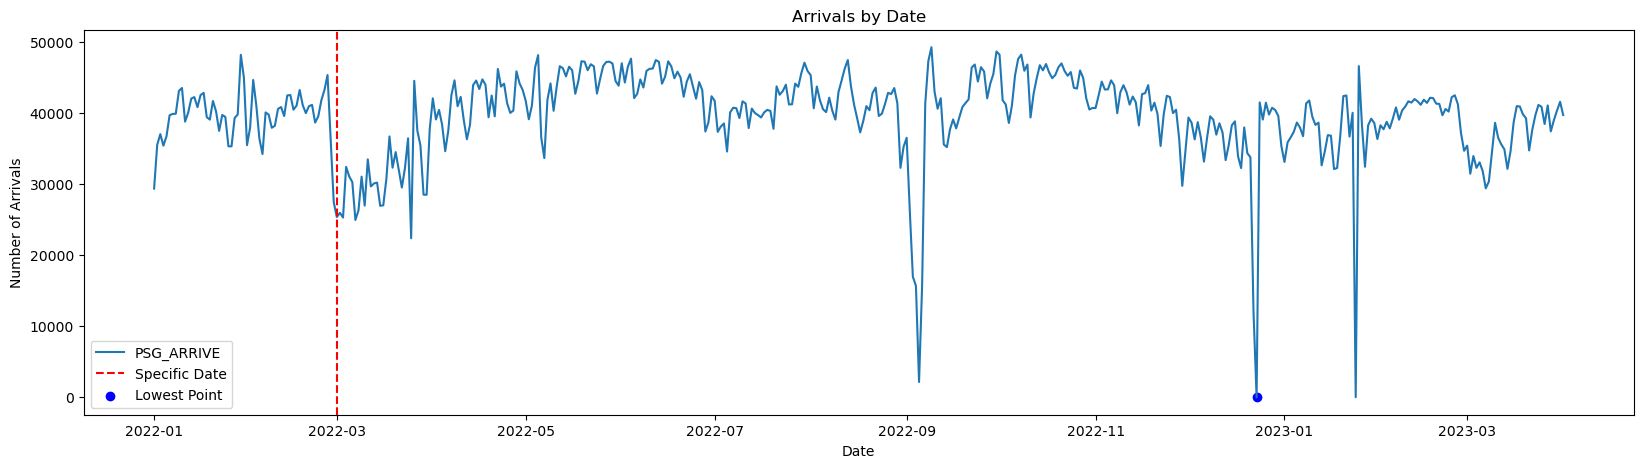

In [6]:
## 가설 1
airportal['DT'] = pd.to_datetime(airportal['DT'])

fig, ax = plt.subplots(figsize=(20, 5))

# ax.plot(airportal['DT'], airportal['AIR_ARRIVE'], label='AIR_ARRIVE')
ax.plot(airportal['DT'], airportal['PSG_ARRIVE'], label='PSG_ARRIVE')

ax.set_title('Arrivals by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Arrivals')

ax.axvline(x=pd.to_datetime('2022-03-01'), color='r', linestyle='--', label='Specific Date')

min_date = airportal.loc[airportal['PSG_ARRIVE'].idxmin()]['DT']
min_val = airportal['PSG_ARRIVE'].min()

ax.scatter(min_date, min_val, color='b', label='Lowest Point')

ax.legend()

plt.show()

In [7]:
sample = dataset.query("DEPART_DATE == '2022-03-01' and AIRLINE == '7C' and DEPART == 'GMP'")
sample = sample.groupby(["LEAD_TIME", "CLASS_DESC"], as_index = False).agg({"FARE": ["count", "min", "max", "mean", "median", "std", "var"]})
sample = sample.sort_values(["LEAD_TIME", "CLASS_DESC"], ascending = [False, True])
sample = sample.reset_index(drop = True)

# sample.columns = ["LEAD_TIME", "CLASS", "TICKET_CNT", "FARE_MIN", "FARE_MAX", "FARE_AVG"]

# sample = pd.pivot_table(sample, values = ["TICKET_CNT", "FARE_MIN", "FARE_MAX", "FARE_AVG"], columns = "CLASS", index = "LEAD_TIME")
sample = pd.pivot_table(sample, columns = "CLASS_DESC", index = "LEAD_TIME")
sample = sample.sort_values("LEAD_TIME", ascending = False)
sample.round(2)[-30:]

/var/folders/57/v1_tz5r94r96fj6p0pz0mqvw0000gn/T/ipykernel_8327/2335727169.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  sample = pd.pivot_table(sample, columns = "CLASS_DESC", index = "LEAD_TIME")
/var/folders/57/v1_tz5r94r96fj6p0pz0mqvw0000gn/T/ipykernel_8327/2335727169.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  sample = pd.pivot_table(sample, columns = "CLASS_DESC", index = "LEAD_TIME")


FARE                                                         \
           count                        max                               
CLASS_DESC     A     B    C     D         A         B        C        D   
LEAD_TIME                                                                 
32           4.0  20.0  3.0  17.0   86900.0  106500.0  41900.0  29900.0   
31           4.0  20.0  2.0  18.0   86900.0  106500.0  41900.0  29900.0   
30           4.0  20.0  2.0  18.0   86900.0  106500.0  41900.0  29900.0   
29           4.0  20.0  2.0  18.0   86900.0  106500.0  41900.0  29900.0   
28           4.0  20.0  2.0  18.0   86900.0  106500.0  41900.0  29900.0   
27           4.0  20.0  2.0  18.0   86900.0  106500.0  41900.0  29900.0   
26           4.0  20.0  2.0  18.0   86900.0  106500.0  41900.0  29900.0   
25           4.0  20.0  3.0  17.0   86900.0  106500.0  41900.0  29900.0   
24           4.0  20.0  2.0  18.0   86900.0  106500.0  41900.0  29900.0   
23           4.0  20.0  3.0  17.0   86900.0  106500.0  41900.0  29900.0   
21           4.0  20.0  2.0  18.0   86900.0  106500.0  41900.0  29900.0   
20           4.0  20.0  2.0  18.0  132000.0  106500.0  41900.0  29900.0   
19           4.0  20.0  2.0  18.0  132000.0  106500.0  37900.0  25900.0   
18           4.0  20.0  2.0  18.0   86900.0  106500.0  37900.0  25900.0   
17           4.0  20.0  1.0  19.0   86900.0  106500.0  33900.0  29900.0   
15           4.0  20.0  1.0  19.0   86900.0  106500.0  33900.0  29900.0   
14           4.0  20.0  1.0  19.0   86900.0  106500.0  33900.0  29900.0   
13           4.0  20.0  NaN  20.0   86900.0  106500.0      NaN  29900.0   
12           4.0  20.0  NaN  20.0   41900.0  106500.0      NaN  25900.0   
11           4.0  20.0  NaN  20.0   41900.0  106500.0      NaN  21900.0   
10           4.0  20.0  NaN  20.0   41900.0  106500.0      NaN  21900.0   
9            4.0  20.0  NaN  20.0   61900.0  106500.0      NaN  21900.0   
8            8.0  40.0  NaN  40.0   61900.0  106500.0      NaN  25900.0   
7            4.0  20.0  NaN  20.0   61900.0  106500.0      NaN  25900.0   
6            4.0  20.0  NaN  20.0   61900.0  106500.0      NaN  17900.0   
5            4.0  25.0  NaN  25.0  157500.0  106500.0      NaN  17900.0   
4            3.0  25.0  NaN  25.0  157500.0  106500.0      NaN  21900.0   
3            3.0  25.0  NaN  25.0  157500.0  106500.0      NaN  21900.0   
2            3.0  25.0  NaN  25.0  157500.0  106500.0      NaN  17900.0   
1            3.0  25.0  NaN  25.0  157500.0  106500.0      NaN  11300.0   

                                                                         \
                 mean                                  median             
CLASS_DESC          A         B         C         D         A         B   
LEAD_TIME                                                                 
32           86900.00  106500.0  37900.00  19723.53   86900.0  106500.0   
31           86900.00  106500.0  39900.00  20511.11   86900.0  106500.0   
30           86900.00  106500.0  39900.00  20733.33   86900.0  106500.0   
29           86900.00  106500.0  39900.00  20955.56   86900.0  106500.0   
28           86900.00  106500.0  39900.00  20955.56   86900.0  106500.0   
27           86900.00  106500.0  39900.00  20900.00   86900.0  106500.0   
26           86900.00  106500.0  37900.00  20344.44   86900.0  106500.0   
25           86900.00  106500.0  36566.67  19782.35   86900.0  106500.0   
24           86900.00  106500.0  41900.00  20344.44   86900.0  106500.0   
23           86900.00  106500.0  39233.33  19547.06   86900.0  106500.0   
21           86900.00  106500.0  39900.00  18844.44   86900.0  106500.0   
20           98175.00  106500.0  39900.00  18844.44   86900.0  106500.0   
19           98175.00  106500.0  35900.00  16955.56   86900.0  106500.0   
18           86900.00  106500.0  35900.00  17400.00   86900.0  106500.0   
17           86900.00  106500.0  33900.00  15847.37   86900.0  106500.0   
15           86900.00  106500.0  339

<AxesSubplot:xlabel='LEAD_TIME'>

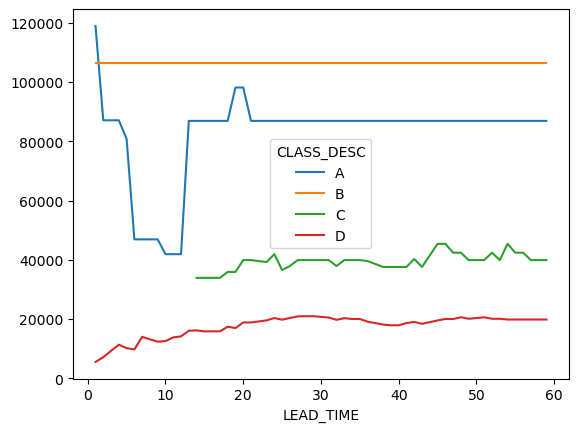

In [8]:
sample["FARE", "mean"].plot()

- D-day가 다가올 수록 할인석(C)은 닫고 특가석(D)는 확대한다.
- 평균가격은 하락 추세를 이어가다가 마지막 D-5부터 상승하는 것을 확인 할 수 있는데, 이는 비즈니스석(A)에서 더 비싼 티켓만이 남은 이유로 추측한다.

탑승객 수와 모든 변수간 상관관계를 파악한다.

In [9]:
pv_fare_seat_df = pd.pivot_table(dataset2 , index = ["DEPART_DATE", "LEAD_TIME"], values = ["FARE", "AVAIL_SEAT"], aggfunc = ["count", "mean", "min", "max", "std", "var"]).reset_index()
pv_fare_seat_df.columns = ["DEPART_DATE", "LEAD_TIME", "FARE_CNT", "SEAT_CNT", "FARE_AVG", "SEAT_AVG", "FARE_MIN", "SEAT_MIN", "FARE_MAX", "SEAT_MAX", "FARE_STD", "SEAT_STD", "FARE_VAR", "SEAT_VAR"]

display(pv_fare_seat_df)

,DEPART_DATE,LEAD_TIME,FARE_CNT,SEAT_CNT,FARE_AVG,SEAT_AVG,FARE_MIN,SEAT_MIN,FARE_MAX,SEAT_MAX,FARE_STD,SEAT_STD,FARE_VAR,SEAT_VAR
0,2022-01-02,1,320,320,7.806250,58249.656250,1,3900,9,160000,2.344865,48314.252532,5.498393,2.334267e+09
1,2022-01-03,1,245,245,6.628571,60033.714286,1,3200,9,146000,3.044210,41581.234858,9.267213,1.728999e+09
2,2022-01-03,2,258,258,7.162791,57954.922481,1,3200,9,146000,2.779275,41265.940594,7.724369,1.702878e+09
3,2022-01-04,1,261,261,7.095785,55788.390805,1,3200,9,146000,2.748850,33425.488520,7.556174,1.117263e+09
4,2022-01-04,2,277,277,7.444043,51413.574007,1,3200,9,146000,2.593458,34862.350075,6.726024,1.215383e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17607,2023-01-26,56,256,256,8.031250,92483.281250,1,23320,9,177000,2.053930,44662.735463,4.218627,1.994760e+09
17608,2023-01-27,57,256,256,7.867188,96830.937500,1,39220,9,177000,2.276465,40352.835592,5.182292,1.628351e+09
17609,2023-01-28,58,258,258,8.015504,92686.589147,1,22000,9,177000,2.158990,43026.344206,4.661237,1.851266e+09
17610,2023-01-29,59,276,276,7.855072,72475.615942,1,20800,9,160000,2.332539,41217.280365,5.440738,1.698864e+09


In [10]:
## 리드타임 기준, FARE에 대한 pivoting
pv_fare_seat_df2 = pv_fare_seat_df.query("LEAD_TIME < 15")
pv_fare_seat_df2 = pv_fare_seat_df2.groupby("DEPART_DATE").mean()
pv_fare_seat_df2 = pv_fare_seat_df2.drop("LEAD_TIME", axis = 1)
pv_fare_seat_df2 = pv_fare_seat_df2.reset_index(drop = False)
pv_fare_seat_df2["DOW"] = pv_fare_seat_df2["DEPART_DATE"].dt.dayofweek

pv_fare_seat_df2 = pd.merge(pv_fare_seat_df2, holiday_2022, left_on="DEPART_DATE", right_on="DT", how="left")
pv_fare_seat_df2 = pd.merge(pv_fare_seat_df2, airportal, left_on="DEPART_DATE", right_on="DT", how="left")
pv_fare_seat_df2 = pd.merge(pv_fare_seat_df2, weather_2022, left_on="DEPART_DATE", right_on="DT", how="left")

pv_fare_seat_df2 = pv_fare_seat_df2.drop(["DT_x", "DT_y", "DT", "DESC"], axis = 1)

pv_fare_seat_df2 = pd.get_dummies(pv_fare_seat_df2, columns=["DOW"])
pv_fare_seat_df2 = pd.get_dummies(pv_fare_seat_df2, columns=["HOLIDAY"])

pv_fare_seat_df2 = pv_fare_seat_df2.drop("AIR_ARRIVE", axis = 1)

display(pv_fare_seat_df2)

,DEPART_DATE,FARE_CNT,SEAT_CNT,FARE_AVG,SEAT_AVG,FARE_MIN,SEAT_MIN,FARE_MAX,SEAT_MAX,FARE_STD,SEAT_STD,FARE_VAR,SEAT_VAR,PSG_ARRIVE,SNOW,RAIN,TEMP,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HOLIDAY_N,HOLIDAY_Y
0,2022-01-02,320.000000,320.000000,7.806250,58249.656250,1.00,3900.000000,9.0,160000.0,2.344865,48314.252532,5.498393,2.334267e+09,35494,0.0,0.00,5.2,0,0,0,0,0,0,1,0,0
1,2022-01-03,251.500000,251.500000,6.895681,58994.318383,1.00,3200.000000,9.0,146000.0,2.911742,41423.587726,8.495791,1.715938e+09,37002,0.0,0.00,5.1,1,0,0,0,0,0,0,0,0
2,2022-01-04,272.333333,272.333333,7.349596,53047.536658,1.00,3266.666667,9.0,146000.0,2.604510,34849.368866,6.796377,1.215818e+09,35380,0.0,0.00,5.4,0,1,0,0,0,0,0,0,0
3,2022-01-05,260.750000,260.750000,7.070781,57400.209054,1.00,6125.000000,9.0,146000.0,2.841673,37576.913976,8.088456,1.413064e+09,36699,0.0,16.27,5.5,0,0,1,0,0,0,0,0,0
4,2022-01-06,252.200000,252.200000,6.728485,60095.537026,1.00,13854.000000,9.0,146000.0,2.938413,29673.159620,8.653589,8.953916e+08,39652,0.0,0.00,6.6,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2023-01-10,273.400000,273.400000,7.569067,63005.040077,1.00,11700.000000,9.0,146000.0,2.461984,36106.669129,6.066487,1.303762e+09,39425,0.0,0.00,6.9,0,1,0,0,0,0,0,0,0
374,2023-01-11,274.750000,274.750000,7.636430,61112.821227,1.25,14150.000000,9.0,146000.0,2.421216,36964.149920,5.906943,1.366482e+09,38301,0.0,0.00,9.4,0,0,1,0,0,0,0,0,0
375,2023-01-12,215.333333,215.333333,7.154853,68293.886838,1.00,28566.666667,9.0,146000.0,2.731594,32387.945896,7.461610,1.049133e+09,38617,0.0,6.70,9.5,0,0,0,1,0,0,0,0,0
376,2023-01-13,242.500000,242.500000,7.501216,100954.959358,1.00,46240.000000,9.0,177000.0,2.587764,35707.925731,6.701805,1.275056e+09,32618,0.0,18.35,16.0,0,0,0,0,1,0,0,0,0


In [11]:
pv_fare_seat_df2.corr()["PSG_ARRIVE"].abs().sort_values(ascending = False)

PSG_ARRIVE    1.000000
FARE_VAR      0.688542
FARE_STD      0.675115
FARE_AVG      0.533728
SEAT_AVG      0.441174
SEAT_MIN      0.430560
SEAT_CNT      0.426627
FARE_CNT      0.426627
SEAT_STD      0.396948
SEAT_VAR      0.393562
RAIN          0.364693
SNOW          0.330816
TEMP          0.306221
DOW_1         0.178462
FARE_MAX      0.124073
SEAT_MAX      0.091491
DOW_3         0.074079
DOW_6         0.056978
DOW_4         0.054072
FARE_MIN      0.047219
DOW_5         0.040312
DOW_2         0.031072
HOLIDAY_Y     0.030292
DOW_0         0.015907
HOLIDAY_N     0.000325
Name: PSG_ARRIVE, dtype: float64

[가설 2]

FARE의 통계량과 탑승객 수가 연관이 있을 것이다.

100%|██████████| 60/60 [00:00<00:00, 179.63it/s]


<AxesSubplot:xlabel='LEAD_TIME'>

,FARE_CNT,FARE_AVG,FARE_MIN,FARE_MAX,FARE_STD,FARE_VAR
LEAD_TIME,,,,,,
1,-0.414828,0.497600,0.472311,0.064950,-0.439709,-0.441841
2,-0.427610,0.470487,0.463916,0.060588,-0.431501,-0.428110
3,-0.423202,0.458808,0.448102,0.068910,-0.416556,-0.413428
4,-0.395485,0.455374,0.423463,0.106305,-0.416059,-0.412871
5,-0.387875,0.461159,0.425138,0.116192,-0.394223,-0.390067
6,-0.383613,0.438315,0.393773,0.140617,-0.337497,-0.334743
7,-0.373114,0.415119,0.368712,0.105654,-0.339548,-0.340585
8,-0.368792,0.397725,0.368986,0.104462,-0.332129,-0.337142
9,-0.366939,0.382999,0.347737,0.093507,-0.342282,-0.349244


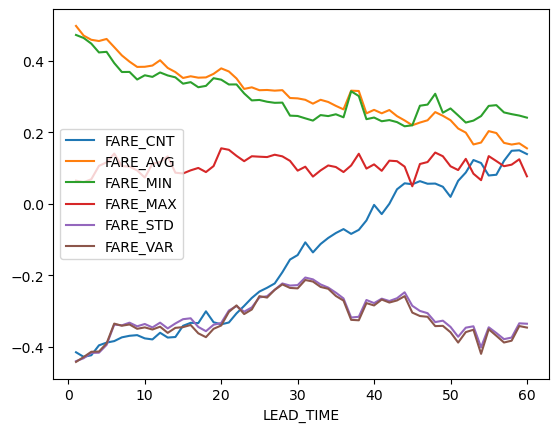

In [12]:
## 가설 2
pv_fare_df = pd.pivot_table(dataset2 , index = ["DEPART_DATE", "LEAD_TIME"], values = "FARE", aggfunc = ["count", "mean", "min", "max", "std", "var"]).reset_index()
pv_fare_df.columns = ["DEPART_DATE", "LEAD_TIME", "FARE_CNT", "FARE_AVG", "FARE_MIN", "FARE_MAX", "FARE_STD", "FARE_VAR"]

# display(pv_fare_df)

corr_df = pd.DataFrame()

for i in trange(1, 61):
    sample_dataset = pv_fare_df.query(f"LEAD_TIME == {i}")

    sample2 = sample_dataset.groupby(["DEPART_DATE", "LEAD_TIME"]).mean()
    # sample2 = sample2.drop("LEAD_TIME", axis = 1)
    sample2 = sample2.sort_values(["DEPART_DATE", "LEAD_TIME"])
    sample2 = sample2.reset_index()

    sample2 = pd.merge(sample2, airportal, left_on = "DEPART_DATE", right_on = "DT")
    sample2 = sample2.drop("DT", axis = 1)

    df = pd.DataFrame(sample2.corr()["PSG_ARRIVE"]).T.reset_index()

    df["LEAD_TIME"] = i

    corr_df = corr_df.append(df)

corr_df = corr_df.drop(["index", "AIR_ARRIVE", "PSG_ARRIVE"], axis = 1)
corr_df = corr_df.set_index("LEAD_TIME")

display(corr_df.plot(), corr_df)

예상대로 가격과 관련하여 높은 상관관계를 보인다.

또한 LEAD_TIME이 가까워질수록 상관관계가 더욱 강해지는 것을 확인할 수 있다.

즉, 유효한 LEAD_TIME 구간을 설정하여 모델링을 진행해야한다.

[좌석수 제외 이유]

항공권 특성상 좌석수는 최대 9까지만 노출된다.

즉, 좌석수 데이터를 활용해서 유의미한 데이터(전체 좌석수, 전체 잔여 좌석수 등)를 도출하기 어렵다.

따라서 가격 데이터를 활용해서 데이터 분석을 진행한다.

하지만 의외로 상관관계에서는 강한 음의 관계를 보이고있어, 추후에 좌석에 대한 변수를 추가하여 모델링을 다시 시도한다.

In [13]:
test2 = pv_fare_df.query("LEAD_TIME < 15") # D-1 ~ D-14

test2_pv = test2.pivot(index='DEPART_DATE', columns='LEAD_TIME', values=["FARE_CNT", "FARE_AVG", "FARE_MIN", "FARE_MAX", "FARE_STD", "FARE_VAR"])
test2_pv = test2_pv.reset_index(drop = False)
test2_pv

DEPART_DATE FARE_CNT                                              \
LEAD_TIME                    1      2      3      4      5   6   7   8   9   
0          2022-01-02    320.0    NaN    NaN    NaN    NaN NaN NaN NaN NaN   
1          2022-01-03    245.0  258.0    NaN    NaN    NaN NaN NaN NaN NaN   
2          2022-01-04    261.0  277.0  279.0    NaN    NaN NaN NaN NaN NaN   
3          2022-01-05    243.0  260.0  267.0  273.0    NaN NaN NaN NaN NaN   
4          2022-01-06    195.0  249.0  269.0  273.0  275.0 NaN NaN NaN NaN   
..                ...      ...    ...    ...    ...    ...  ..  ..  ..  ..   
373        2023-01-10      NaN    NaN    NaN    NaN    NaN NaN NaN NaN NaN   
374        2023-01-11      NaN    NaN    NaN    NaN    NaN NaN NaN NaN NaN   
375        2023-01-12      NaN    NaN    NaN    NaN    NaN NaN NaN NaN NaN   
376        2023-01-13      NaN    NaN    NaN    NaN    NaN NaN NaN NaN NaN   
377        2023-01-14      NaN    NaN    NaN    NaN    NaN NaN NaN NaN NaN   

                                                  FARE_AVG                \
LEAD_TIME     10     11     12     13     14             1             2   
0            NaN    NaN    NaN    NaN    NaN  58249.656250           NaN   
1            NaN    NaN    NaN    NaN    NaN  60033.714286  57954.922481   
2            NaN    NaN    NaN    NaN    NaN  55788.390805  51413.574007   
3            NaN    NaN    NaN    NaN    NaN  61960.164609  57486.307692   
4            NaN    NaN    NaN    NaN    NaN  72158.051282  60248.554217   
..           ...    ...    ...    ...    ...           ...           ...   
373        276.0  275.0  277.0  276.0  263.0           NaN           NaN   
374          NaN  283.0  284.0  265.0  267.0           NaN           NaN   
375          NaN    NaN  156.0  244.0  246.0           NaN           NaN   
376          NaN    NaN    NaN  242.0  243.0           NaN           NaN   
377          NaN    NaN    NaN    NaN  275.0           NaN           NaN   

                                                                     \
LEAD_TIME             3             4             5   6   7   8   9   
0                   NaN           NaN           NaN NaN NaN NaN NaN   
1                   NaN           NaN           NaN NaN NaN NaN NaN   
2          51940.645161           NaN           NaN NaN NaN NaN NaN   
3          54900.224719  55254.139194           NaN NaN NaN NaN NaN   
4          55960.557621  56236.776557  55873.745455 NaN NaN NaN NaN   
..                  ...           ...           ...  ..  ..  ..  ..   
373                 NaN           NaN           NaN NaN NaN NaN NaN   
374                 NaN           NaN           NaN NaN NaN NaN NaN   
375                 NaN           NaN           NaN NaN NaN NaN NaN   
376                 NaN           NaN           NaN NaN NaN NaN NaN   
377                 NaN           NaN           NaN NaN NaN NaN NaN   

                                                                    \
LEAD_TIME            10            11            12             13   
0                   NaN           NaN           NaN            NaN   
1                   NaN           NaN           NaN            NaN   
2                   NaN           NaN           NaN            NaN   
3                   NaN           NaN           NaN            NaN   
4                   NaN           NaN           NaN            NaN   
..                  ...           ...           ...            ...   
373        63301.811594  63245.272727  62706.353791   62544.347826   
374                 NaN  61097.632509  61211.936620   60739.056604   
375                 NaN           NaN  65499.423077   69815.204918   
376                 NaN           NaN           NaN  101030.247934   
377                 NaN           NaN           NaN            NaN   

                         FARE_MIN                                           \
LEAD_TIME             14        1        2       3       4       5   6   7   
0              

시계열 예측 모델 적용을 위하여 시간 순서대로 배열된 일련의 관측값 형태로 변환하였다.

문제는 NaN값이 발생한다. 이유는 아래와 같다.

1. 크롤링 시작 시점을 기준으로 D+60 ~ D+1 까지 이어지기 때문에, 데이터수집이 불가능했던 구간에서 결측값이 발생한다.
2. 크롤링이 정상작동되지 않은 날에는 데이터 수집을 실패하여 결측값이 발생한다.

이러한 문제를 해결하기 위해서는 아래의 방법을 생각해볼 수 있다.

1. 결측값 제거 - 데이터 양이 많지만 결측값이 적은 경우
2. 결측값 대체 - 데이터 양이 적지만 결측값이 많은 경우, 통계값을 임의로 넣는다
3. 결측값 보간 - 데이터 양이 적지만 결측값이 많은 경우, 주변값을 활용하여 추정값을 넣는다

문제1의 경우는 제거, 문제2의 경우는 보간을 사용하는게 설득력있다고 판단한다.


In [15]:
## 데이터 수집 불가능 - 제거
test3 = test2_pv[13:364] 
test3 = test3.reset_index(drop = True)

display(test3)

DEPART_DATE FARE_CNT                                            \
LEAD_TIME                    1      2      3      4      5      6      7   
0          2022-01-15    261.0  277.0  286.0  298.0  304.0  494.0  501.0   
1          2022-01-16    276.0  284.0  281.0  297.0  310.0  310.0  519.0   
2          2022-01-17      NaN  146.0  175.0  209.0  236.0  257.0  281.0   
3          2022-01-18    192.0    NaN  227.0  231.0  254.0  266.0  275.0   
4          2022-01-19    203.0  244.0    NaN  264.0  268.0  275.0  282.0   
..                ...      ...    ...    ...    ...    ...    ...    ...   
346        2022-12-27     97.0    NaN    NaN    NaN  180.0  191.0  195.0   
347        2022-12-28    121.0  152.0    NaN    NaN    NaN  167.0  204.0   
348        2022-12-29     99.0  125.0  140.0    NaN    NaN    NaN  153.0   
349        2022-12-30    188.0  205.0  200.0  212.0    NaN    NaN    NaN   
350        2022-12-31    245.0  259.0  266.0  156.0  169.0    NaN    NaN   

                                                                FARE_AVG  \
LEAD_TIME      8      9     10     11     12     13     14             1   
0          308.0  309.0  310.0  308.0  307.0  309.0  307.0  99082.528736   
1          520.0  313.0  313.0  316.0  316.0  318.0  318.0  93041.195652   
2          460.0  468.0  298.0  298.0  300.0  301.0  302.0           NaN   
3          279.0  474.0  476.0  282.0  283.0  284.0  284.0  71417.552083   
4          284.0  285.0  489.0  494.0  292.0  293.0  294.0  68348.719212   
..           ...    ...    ...    ...    ...    ...    ...           ...   
346        187.0  200.0  200.0  202.0  205.0  212.0  214.0  87592.783505   
347        209.0  206.0  205.0  202.0  208.0  214.0  204.0  86455.371901   
348        158.0  158.0  160.0  170.0  171.0  167.0  169.0  80488.484848   
349        197.0  196.0  195.0  194.0  198.0  197.0  195.0  84146.914894   
350          NaN  244.0  232.0  232.0  219.0  228.0  226.0  75267.265306   

                                                                   \
LEAD_TIME             2             3             4             5   
0          95583.393502  93674.895105  88657.651007  85740.197368   
1          88798.978873  87757.366548  84626.161616  78322.838710   
2          75035.342466  71176.628571  74001.483254  73377.203390   
3                   NaN  70787.136564  67056.580087  66701.811024   
4          64762.581967           NaN  63774.886364  61551.492537   
..                  ...           ...           ...           ...   
346                 NaN           NaN           NaN  79311.722222   
347        83598.684211           NaN           NaN           NaN   
348        77330.800000  76668.357143           NaN           NaN   
349        81221.463415  82157.000000  85402.641509           NaN   
350        75983.861004  75136.315789  67413.846154  78885.325444   

                                                                    \
LEAD_TIME             6             7             8              9   
0          77668.137652  76185.249501  82922.792208   81417.928803   
1          75561.354839  67394.315992  65738.807692   71235.527157   
2          69032.607004  66410.106762  60509.391304   59282.927350   
3          65017.706767  61368.072727  60719.892473   53512.236287   
4          60935.418182  60320.531915  56492.042254   55271.017544   
..                  ...           ...           ...            ...   
346        78666.387435  78692.256410  76474.919786   77888.650000   
347        75752.455090  79295.294118  78679.952153   78315.825243   
348                 NaN  78002.549020  78167.531646   79609.177215   
349                 NaN           NaN  95863.959391  100622.653061   
350                 NaN           NaN           NaN   89919.344262   

                                                                       \
LEAD_TIME             10             11             12             13   
0           80720.451613   81558.051948   82642.084691   82211.197411   
1   

In [16]:
## 크롤링 수집 실패 - 보간
fare_cnt_df = test3['FARE_CNT'].interpolate(limit_direction='both', axis = 1)
fare_cnt_df.columns = ["FARE_CNT_1", "FARE_CNT_2", "FARE_CNT_3", "FARE_CNT_4", "FARE_CNT_5", "FARE_CNT_6", "FARE_CNT_7", "FARE_CNT_8", "FARE_CNT_9", "FARE_CNT_10", "FARE_CNT_11", "FARE_CNT_12", "FARE_CNT_13", "FARE_CNT_14"]

fare_avg_df = test3['FARE_AVG'].interpolate(limit_direction='both', axis = 1)
fare_avg_df.columns = ["FARE_AVG_1", "FARE_AVG_2", "FARE_AVG_3", "FARE_AVG_4", "FARE_AVG_5", "FARE_AVG_6", "FARE_AVG_7", "FARE_AVG_8", "FARE_AVG_9", "FARE_AVG_10", "FARE_AVG_11", "FARE_AVG_12", "FARE_AVG_13", "FARE_AVG_14"]

fare_min_df = test3['FARE_MIN'].interpolate(limit_direction='both', axis = 1)
fare_min_df.columns = ["FARE_MIN_1", "FARE_MIN_2", "FARE_MIN_3", "FARE_MIN_4", "FARE_MIN_5", "FARE_MIN_6", "FARE_MIN_7", "FARE_MIN_8", "FARE_MIN_9", "FARE_MIN_10", "FARE_MIN_11", "FARE_MIN_12", "FARE_MIN_13", "FARE_MIN_14"]

fare_max_df = test3['FARE_MAX'].interpolate(limit_direction='both', axis = 1)
fare_max_df.columns = ["FARE_MAX_1", "FARE_MAX_2", "FARE_MAX_3", "FARE_MAX_4", "FARE_MAX_5", "FARE_MAX_6", "FARE_MAX_7", "FARE_MAX_8", "FARE_MAX_9", "FARE_MAX_10", "FARE_MAX_11", "FARE_MAX_12", "FARE_MAX_13", "FARE_MAX_14"]

fare_std_df = test3['FARE_STD'].interpolate(limit_direction='both', axis = 1)
fare_std_df.columns = ["FARE_STD_1", "FARE_STD_2", "FARE_STD_3", "FARE_STD_4", "FARE_STD_5", "FARE_STD_6", "FARE_STD_7", "FARE_STD_8", "FARE_STD_9", "FARE_STD_10", "FARE_STD_11", "FARE_STD_12", "FARE_STD_13", "FARE_STD_14"]

fare_var_df = test3['FARE_VAR'].interpolate(limit_direction='both', axis = 1)
fare_var_df.columns = ["FARE_VAR_1", "FARE_VAR_2", "FARE_VAR_3", "FARE_VAR_4", "FARE_VAR_5", "FARE_VAR_6", "FARE_VAR_7", "FARE_VAR_8", "FARE_VAR_9", "FARE_VAR_10", "FARE_VAR_11", "FARE_VAR_12", "FARE_VAR_13", "FARE_VAR_14"]

test4 = pd.concat([test3["DEPART_DATE"], fare_cnt_df, fare_avg_df, fare_min_df, fare_max_df, fare_std_df, fare_var_df], axis = 1)
# test4 = pd.concat([test3["DEPART_DATE"], fare_cnt_df, fare_avg_df, fare_min_df, fare_max_df], axis = 1)

display(test4)


,DEPART_DATE,FARE_CNT_1,FARE_CNT_2,FARE_CNT_3,FARE_CNT_4,FARE_CNT_5,FARE_CNT_6,FARE_CNT_7,FARE_CNT_8,FARE_CNT_9,FARE_CNT_10,FARE_CNT_11,FARE_CNT_12,FARE_CNT_13,FARE_CNT_14,FARE_AVG_1,FARE_AVG_2,FARE_AVG_3,FARE_AVG_4,FARE_AVG_5,FARE_AVG_6,FARE_AVG_7,FARE_AVG_8,FARE_AVG_9,FARE_AVG_10,FARE_AVG_11,FARE_AVG_12,FARE_AVG_13,FARE_AVG_14,FARE_MIN_1,FARE_MIN_2,FARE_MIN_3,FARE_MIN_4,FARE_MIN_5,FARE_MIN_6,FARE_MIN_7,FARE_MIN_8,FARE_MIN_9,FARE_MIN_10,FARE_MIN_11,FARE_MIN_12,FARE_MIN_13,FARE_MIN_14,FARE_MAX_1,FARE_MAX_2,FARE_MAX_3,FARE_MAX_4,FARE_MAX_5,FARE_MAX_6,FARE_MAX_7,FARE_MAX_8,FARE_MAX_9,FARE_MAX_10,FARE_MAX_11,FARE_MAX_12,FARE_MAX_13,FARE_MAX_14,FARE_STD_1,FARE_STD_2,FARE_STD_3,FARE_STD_4,FARE_STD_5,FARE_STD_6,FARE_STD_7,FARE_STD_8,FARE_STD_9,FARE_STD_10,FARE_STD_11,FARE_STD_12,FARE_STD_13,FARE_STD_14,FARE_VAR_1,FARE_VAR_2,FARE_VAR_3,FARE_VAR_4,FARE_VAR_5,FARE_VAR_6,FARE_VAR_7,FARE_VAR_8,FARE_VAR_9,FARE_VAR_10,FARE_VAR_11,FARE_VAR_12,FARE_VAR_13,FARE_VAR_14
0,2022-01-15,261.0,277.00,286.00,298.00,304.00,494.00,501.00,308.00,309.0,310.0,308.0,307.0,309.0,307.0,99082.528736,95583.393502,93674.895105,88657.651007,85740.197368,77668.137652,76185.249501,82922.792208,81417.928803,80720.451613,81558.051948,82642.084691,82211.197411,81805.993485,35900.0,29900.0,22000.0,20000.0,20900.0,14900.0,9400.0,16800.0,15900.0,15900.0,16900.0,17100.0,17100.0,14400.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,30809.220519,34906.885601,38114.055986,38191.413333,39922.720414,37315.787774,38376.549957,42750.958524,42944.089515,43802.450418,42399.921748,43136.803307,43378.734873,43326.073305,9.492081e+08,1.218491e+09,1.452681e+09,1.458584e+09,1.593824e+09,1.392468e+09,1.472760e+09,1.827644e+09,1.844195e+09,1.918655e+09,1.797753e+09,1.860784e+09,1.881715e+09,1.877149e+09
1,2022-01-16,276.0,284.00,281.00,297.00,310.00,310.00,519.00,520.00,313.0,313.0,316.0,316.0,318.0,318.0,93041.195652,88798.978873,87757.366548,84626.161616,78322.838710,75561.354839,67394.315992,65738.807692,71235.527157,69733.514377,68352.658228,69676.265823,69548.459119,68481.352201,58900.0,50000.0,45000.0,29000.0,23900.0,21900.0,16800.0,7900.0,16800.0,14900.0,16900.0,14400.0,14900.0,14400.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,26864.541314,26868.743673,28365.690572,31462.134095,34346.222580,36430.326276,34079.754674,34410.868916,37603.942218,38038.597719,39157.143352,40378.836300,40820.001335,40764.439857,7.217036e+08,7.219294e+08,8.046124e+08,9.898659e+08,1.179663e+09,1.327169e+09,1.161430e+09,1.184108e+09,1.414056e+09,1.446935e+09,1.533282e+09,1.630450e+09,1.666273e+09,1.661740e+09
2,2022-01-17,146.0,146.00,175.00,209.00,236.00,257.00,281.00,460.00,468.0,298.0,298.0,300.0,301.0,302.0,75035.342466,75035.342466,71176.628571,74001.483254,73377.203390,69032.607004,66410.106762,60509.391304,59282.927350,62757.483221,61302.785235,60606.466667,60930.232558,60640.264901,25900.0,25900.0,21900.0,21900.0,15900.0,12800.0,11900.0,10400.0,5900.0,10900.0,8800.0,10900.0,9600.0,11100.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,33758.670348,33758.670348,32881.678677,34588.274847,35411.401118,34350.026687,33077.421437,30153.801027,30112.647854,33187.667815,33359.147307,34186.842462,34735.109715,34736.605142,1.139648e+09,1.139648e+09,1.081205e+09,1.196349e+09,1.253967e+09,1.179924e+09,1.094116e+09,9.092517e+08,9.067716e+08,1.101421e+09,1.112833e+09,1.168740e+09,1.206528e+09,1.206632e+09
3,2022-01-18,192.0,209.50,227.00,231.00,254.00,266.00,275.00,279.00,474.0,476.0,282.0,283.0,284.0,284.0,71417.552083,71102.344324,70787.136564,67056.580087,66701.811024,65017.706767,61368.072727,60719.892473,53512.236287,52664.957983,57113.687943,56271.943463,55610.457746,55057.429577,22000.0,20500.0,19000.0,14900.0,11900.0,10900.0,8700.0,7590.0,5900.0,5900.0,5600.0,6900.

각 칼럼이 뜻하는 데이터가 다르기 때문에 칼럼 분리하여 결측값 보간을 진행하였다.

결측값 보간: row 기준 양방향 선형 보간

In [17]:
## 공휴일 정보 추가 
test5 = pd.merge(test4, holiday_2022, left_on = ["DEPART_DATE"], right_on = ["DT"], how = "left")
test5 = test5.drop(["DT", "DESC"], axis = 1)
# test5["DESC"] = test5["DESC"].fillna("N")
test5["HOLIDAY"] = test5["HOLIDAY"].fillna("N")

test5["DOW"] = test5["DEPART_DATE"].dt.dayofweek

## 범주형 칼럼 원핫인코딩
test5 = pd.get_dummies(test5, columns=["DOW"])
test5 = pd.get_dummies(test5, columns=["HOLIDAY"])

display(test5)

,DEPART_DATE,FARE_CNT_1,FARE_CNT_2,FARE_CNT_3,FARE_CNT_4,FARE_CNT_5,FARE_CNT_6,FARE_CNT_7,FARE_CNT_8,FARE_CNT_9,FARE_CNT_10,FARE_CNT_11,FARE_CNT_12,FARE_CNT_13,FARE_CNT_14,FARE_AVG_1,FARE_AVG_2,FARE_AVG_3,FARE_AVG_4,FARE_AVG_5,FARE_AVG_6,FARE_AVG_7,FARE_AVG_8,FARE_AVG_9,FARE_AVG_10,FARE_AVG_11,FARE_AVG_12,FARE_AVG_13,FARE_AVG_14,FARE_MIN_1,FARE_MIN_2,FARE_MIN_3,FARE_MIN_4,FARE_MIN_5,FARE_MIN_6,FARE_MIN_7,FARE_MIN_8,FARE_MIN_9,FARE_MIN_10,FARE_MIN_11,FARE_MIN_12,FARE_MIN_13,FARE_MIN_14,FARE_MAX_1,FARE_MAX_2,FARE_MAX_3,FARE_MAX_4,FARE_MAX_5,FARE_MAX_6,FARE_MAX_7,FARE_MAX_8,FARE_MAX_9,FARE_MAX_10,FARE_MAX_11,FARE_MAX_12,FARE_MAX_13,FARE_MAX_14,FARE_STD_1,FARE_STD_2,FARE_STD_3,FARE_STD_4,FARE_STD_5,FARE_STD_6,FARE_STD_7,FARE_STD_8,FARE_STD_9,FARE_STD_10,FARE_STD_11,FARE_STD_12,FARE_STD_13,FARE_STD_14,FARE_VAR_1,FARE_VAR_2,FARE_VAR_3,FARE_VAR_4,FARE_VAR_5,FARE_VAR_6,FARE_VAR_7,FARE_VAR_8,FARE_VAR_9,FARE_VAR_10,FARE_VAR_11,FARE_VAR_12,FARE_VAR_13,FARE_VAR_14,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HOLIDAY_N,HOLIDAY_Y
0,2022-01-15,261.0,277.00,286.00,298.00,304.00,494.00,501.00,308.00,309.0,310.0,308.0,307.0,309.0,307.0,99082.528736,95583.393502,93674.895105,88657.651007,85740.197368,77668.137652,76185.249501,82922.792208,81417.928803,80720.451613,81558.051948,82642.084691,82211.197411,81805.993485,35900.0,29900.0,22000.0,20000.0,20900.0,14900.0,9400.0,16800.0,15900.0,15900.0,16900.0,17100.0,17100.0,14400.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,30809.220519,34906.885601,38114.055986,38191.413333,39922.720414,37315.787774,38376.549957,42750.958524,42944.089515,43802.450418,42399.921748,43136.803307,43378.734873,43326.073305,9.492081e+08,1.218491e+09,1.452681e+09,1.458584e+09,1.593824e+09,1.392468e+09,1.472760e+09,1.827644e+09,1.844195e+09,1.918655e+09,1.797753e+09,1.860784e+09,1.881715e+09,1.877149e+09,0,0,0,0,0,1,0,1,0
1,2022-01-16,276.0,284.00,281.00,297.00,310.00,310.00,519.00,520.00,313.0,313.0,316.0,316.0,318.0,318.0,93041.195652,88798.978873,87757.366548,84626.161616,78322.838710,75561.354839,67394.315992,65738.807692,71235.527157,69733.514377,68352.658228,69676.265823,69548.459119,68481.352201,58900.0,50000.0,45000.0,29000.0,23900.0,21900.0,16800.0,7900.0,16800.0,14900.0,16900.0,14400.0,14900.0,14400.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,26864.541314,26868.743673,28365.690572,31462.134095,34346.222580,36430.326276,34079.754674,34410.868916,37603.942218,38038.597719,39157.143352,40378.836300,40820.001335,40764.439857,7.217036e+08,7.219294e+08,8.046124e+08,9.898659e+08,1.179663e+09,1.327169e+09,1.161430e+09,1.184108e+09,1.414056e+09,1.446935e+09,1.533282e+09,1.630450e+09,1.666273e+09,1.661740e+09,0,0,0,0,0,0,1,1,0
2,2022-01-17,146.0,146.00,175.00,209.00,236.00,257.00,281.00,460.00,468.0,298.0,298.0,300.0,301.0,302.0,75035.342466,75035.342466,71176.628571,74001.483254,73377.203390,69032.607004,66410.106762,60509.391304,59282.927350,62757.483221,61302.785235,60606.466667,60930.232558,60640.264901,25900.0,25900.0,21900.0,21900.0,15900.0,12800.0,11900.0,10400.0,5900.0,10900.0,8800.0,10900.0,9600.0,11100.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,33758.670348,33758.670348,32881.678677,34588.274847,35411.401118,34350.026687,33077.421437,30153.801027,30112.647854,33187.667815,33359.147307,34186.842462,34735.109715,34736.605142,1.139648e+09,1.139648e+09,1.081205e+09,1.196349e+09,1.253967e+09,1.179924e+09,1.094116e+09,9.092517e+08,9.067716e+08,1.101421e+09,1.112833e+09,1.168740e+09,1.206528e+09,1.206632e+09,1,0,0,0,0,0,0,1,0
3,2022-01-18,192.0,209.50,227.00,231.00,254.00,266.00,275.00,279.00,474.0,476.0,282.0,283.0,284.0,284.0,71417.552083,71102.344324,70787.136564,67056.580087,66701.811024,65017.706767,61368.072727,60719.892473,53512.236287,52664.957983,57113.687943,56271.94346

In [18]:
## 날시 정보 추가 
test6 = pd.merge(test5, weather_2022, left_on = "DEPART_DATE", right_on = "DT", how = "left")
test6 = test6.drop(["DT"], axis = 1)

display(test6)

,DEPART_DATE,FARE_CNT_1,FARE_CNT_2,FARE_CNT_3,FARE_CNT_4,FARE_CNT_5,FARE_CNT_6,FARE_CNT_7,FARE_CNT_8,FARE_CNT_9,FARE_CNT_10,FARE_CNT_11,FARE_CNT_12,FARE_CNT_13,FARE_CNT_14,FARE_AVG_1,FARE_AVG_2,FARE_AVG_3,FARE_AVG_4,FARE_AVG_5,FARE_AVG_6,FARE_AVG_7,FARE_AVG_8,FARE_AVG_9,FARE_AVG_10,FARE_AVG_11,FARE_AVG_12,FARE_AVG_13,FARE_AVG_14,FARE_MIN_1,FARE_MIN_2,FARE_MIN_3,FARE_MIN_4,FARE_MIN_5,FARE_MIN_6,FARE_MIN_7,FARE_MIN_8,FARE_MIN_9,FARE_MIN_10,FARE_MIN_11,FARE_MIN_12,FARE_MIN_13,FARE_MIN_14,FARE_MAX_1,FARE_MAX_2,FARE_MAX_3,FARE_MAX_4,FARE_MAX_5,FARE_MAX_6,FARE_MAX_7,FARE_MAX_8,FARE_MAX_9,FARE_MAX_10,FARE_MAX_11,FARE_MAX_12,FARE_MAX_13,FARE_MAX_14,FARE_STD_1,FARE_STD_2,FARE_STD_3,FARE_STD_4,FARE_STD_5,FARE_STD_6,FARE_STD_7,FARE_STD_8,FARE_STD_9,FARE_STD_10,FARE_STD_11,FARE_STD_12,FARE_STD_13,FARE_STD_14,FARE_VAR_1,FARE_VAR_2,FARE_VAR_3,FARE_VAR_4,FARE_VAR_5,FARE_VAR_6,FARE_VAR_7,FARE_VAR_8,FARE_VAR_9,FARE_VAR_10,FARE_VAR_11,FARE_VAR_12,FARE_VAR_13,FARE_VAR_14,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HOLIDAY_N,HOLIDAY_Y,SNOW,RAIN,TEMP
0,2022-01-15,261.0,277.00,286.00,298.00,304.00,494.00,501.00,308.00,309.0,310.0,308.0,307.0,309.0,307.0,99082.528736,95583.393502,93674.895105,88657.651007,85740.197368,77668.137652,76185.249501,82922.792208,81417.928803,80720.451613,81558.051948,82642.084691,82211.197411,81805.993485,35900.0,29900.0,22000.0,20000.0,20900.0,14900.0,9400.0,16800.0,15900.0,15900.0,16900.0,17100.0,17100.0,14400.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,30809.220519,34906.885601,38114.055986,38191.413333,39922.720414,37315.787774,38376.549957,42750.958524,42944.089515,43802.450418,42399.921748,43136.803307,43378.734873,43326.073305,9.492081e+08,1.218491e+09,1.452681e+09,1.458584e+09,1.593824e+09,1.392468e+09,1.472760e+09,1.827644e+09,1.844195e+09,1.918655e+09,1.797753e+09,1.860784e+09,1.881715e+09,1.877149e+09,0,0,0,0,0,1,0,1,0,0.0,1.10,6.6
1,2022-01-16,276.0,284.00,281.00,297.00,310.00,310.00,519.00,520.00,313.0,313.0,316.0,316.0,318.0,318.0,93041.195652,88798.978873,87757.366548,84626.161616,78322.838710,75561.354839,67394.315992,65738.807692,71235.527157,69733.514377,68352.658228,69676.265823,69548.459119,68481.352201,58900.0,50000.0,45000.0,29000.0,23900.0,21900.0,16800.0,7900.0,16800.0,14900.0,16900.0,14400.0,14900.0,14400.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,26864.541314,26868.743673,28365.690572,31462.134095,34346.222580,36430.326276,34079.754674,34410.868916,37603.942218,38038.597719,39157.143352,40378.836300,40820.001335,40764.439857,7.217036e+08,7.219294e+08,8.046124e+08,9.898659e+08,1.179663e+09,1.327169e+09,1.161430e+09,1.184108e+09,1.414056e+09,1.446935e+09,1.533282e+09,1.630450e+09,1.666273e+09,1.661740e+09,0,0,0,0,0,0,1,1,0,0.0,1.03,6.9
2,2022-01-17,146.0,146.00,175.00,209.00,236.00,257.00,281.00,460.00,468.0,298.0,298.0,300.0,301.0,302.0,75035.342466,75035.342466,71176.628571,74001.483254,73377.203390,69032.607004,66410.106762,60509.391304,59282.927350,62757.483221,61302.785235,60606.466667,60930.232558,60640.264901,25900.0,25900.0,21900.0,21900.0,15900.0,12800.0,11900.0,10400.0,5900.0,10900.0,8800.0,10900.0,9600.0,11100.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,33758.670348,33758.670348,32881.678677,34588.274847,35411.401118,34350.026687,33077.421437,30153.801027,30112.647854,33187.667815,33359.147307,34186.842462,34735.109715,34736.605142,1.139648e+09,1.139648e+09,1.081205e+09,1.196349e+09,1.253967e+09,1.179924e+09,1.094116e+09,9.092517e+08,9.067716e+08,1.101421e+09,1.112833e+09,1.168740e+09,1.206528e+09,1.206632e+09,1,0,0,0,0,0,0,1,0,0.0,0.00,5.3
3,2022-01-18,192.0,209.50,227.00,231.00,254.00,266.00,275.00,279.00,474.0,476.0,282.0,283.0,284.0,284.0,71417.552083,71102.344324,70787.136564,67056.580087,66701.811024,65017.706767,61368.072727,60719.892

In [19]:
## 탑승객 정보
test7 = pd.merge(test6, airportal, left_on = "DEPART_DATE", right_on = "DT", how = "left")
test7 = test7.drop("DT", axis = 1)

display(test7)

,DEPART_DATE,FARE_CNT_1,FARE_CNT_2,FARE_CNT_3,FARE_CNT_4,FARE_CNT_5,FARE_CNT_6,FARE_CNT_7,FARE_CNT_8,FARE_CNT_9,FARE_CNT_10,FARE_CNT_11,FARE_CNT_12,FARE_CNT_13,FARE_CNT_14,FARE_AVG_1,FARE_AVG_2,FARE_AVG_3,FARE_AVG_4,FARE_AVG_5,FARE_AVG_6,FARE_AVG_7,FARE_AVG_8,FARE_AVG_9,FARE_AVG_10,FARE_AVG_11,FARE_AVG_12,FARE_AVG_13,FARE_AVG_14,FARE_MIN_1,FARE_MIN_2,FARE_MIN_3,FARE_MIN_4,FARE_MIN_5,FARE_MIN_6,FARE_MIN_7,FARE_MIN_8,FARE_MIN_9,FARE_MIN_10,FARE_MIN_11,FARE_MIN_12,FARE_MIN_13,FARE_MIN_14,FARE_MAX_1,FARE_MAX_2,FARE_MAX_3,FARE_MAX_4,FARE_MAX_5,FARE_MAX_6,FARE_MAX_7,FARE_MAX_8,FARE_MAX_9,FARE_MAX_10,FARE_MAX_11,FARE_MAX_12,FARE_MAX_13,FARE_MAX_14,FARE_STD_1,FARE_STD_2,FARE_STD_3,FARE_STD_4,FARE_STD_5,FARE_STD_6,FARE_STD_7,FARE_STD_8,FARE_STD_9,FARE_STD_10,FARE_STD_11,FARE_STD_12,FARE_STD_13,FARE_STD_14,FARE_VAR_1,FARE_VAR_2,FARE_VAR_3,FARE_VAR_4,FARE_VAR_5,FARE_VAR_6,FARE_VAR_7,FARE_VAR_8,FARE_VAR_9,FARE_VAR_10,FARE_VAR_11,FARE_VAR_12,FARE_VAR_13,FARE_VAR_14,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HOLIDAY_N,HOLIDAY_Y,SNOW,RAIN,TEMP,AIR_ARRIVE,PSG_ARRIVE
0,2022-01-15,261.0,277.00,286.00,298.00,304.00,494.00,501.00,308.00,309.0,310.0,308.0,307.0,309.0,307.0,99082.528736,95583.393502,93674.895105,88657.651007,85740.197368,77668.137652,76185.249501,82922.792208,81417.928803,80720.451613,81558.051948,82642.084691,82211.197411,81805.993485,35900.0,29900.0,22000.0,20000.0,20900.0,14900.0,9400.0,16800.0,15900.0,15900.0,16900.0,17100.0,17100.0,14400.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,177000.0,30809.220519,34906.885601,38114.055986,38191.413333,39922.720414,37315.787774,38376.549957,42750.958524,42944.089515,43802.450418,42399.921748,43136.803307,43378.734873,43326.073305,9.492081e+08,1.218491e+09,1.452681e+09,1.458584e+09,1.593824e+09,1.392468e+09,1.472760e+09,1.827644e+09,1.844195e+09,1.918655e+09,1.797753e+09,1.860784e+09,1.881715e+09,1.877149e+09,0,0,0,0,0,1,0,1,0,0.0,1.10,6.6,238,40794
1,2022-01-16,276.0,284.00,281.00,297.00,310.00,310.00,519.00,520.00,313.0,313.0,316.0,316.0,318.0,318.0,93041.195652,88798.978873,87757.366548,84626.161616,78322.838710,75561.354839,67394.315992,65738.807692,71235.527157,69733.514377,68352.658228,69676.265823,69548.459119,68481.352201,58900.0,50000.0,45000.0,29000.0,23900.0,21900.0,16800.0,7900.0,16800.0,14900.0,16900.0,14400.0,14900.0,14400.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,160000.0,26864.541314,26868.743673,28365.690572,31462.134095,34346.222580,36430.326276,34079.754674,34410.868916,37603.942218,38038.597719,39157.143352,40378.836300,40820.001335,40764.439857,7.217036e+08,7.219294e+08,8.046124e+08,9.898659e+08,1.179663e+09,1.327169e+09,1.161430e+09,1.184108e+09,1.414056e+09,1.446935e+09,1.533282e+09,1.630450e+09,1.666273e+09,1.661740e+09,0,0,0,0,0,0,1,1,0,0.0,1.03,6.9,244,42494
2,2022-01-17,146.0,146.00,175.00,209.00,236.00,257.00,281.00,460.00,468.0,298.0,298.0,300.0,301.0,302.0,75035.342466,75035.342466,71176.628571,74001.483254,73377.203390,69032.607004,66410.106762,60509.391304,59282.927350,62757.483221,61302.785235,60606.466667,60930.232558,60640.264901,25900.0,25900.0,21900.0,21900.0,15900.0,12800.0,11900.0,10400.0,5900.0,10900.0,8800.0,10900.0,9600.0,11100.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,146000.0,33758.670348,33758.670348,32881.678677,34588.274847,35411.401118,34350.026687,33077.421437,30153.801027,30112.647854,33187.667815,33359.147307,34186.842462,34735.109715,34736.605142,1.139648e+09,1.139648e+09,1.081205e+09,1.196349e+09,1.253967e+09,1.179924e+09,1.094116e+09,9.092517e+08,9.067716e+08,1.101421e+09,1.112833e+09,1.168740e+09,1.206528e+09,1.206632e+09,1,0,0,0,0,0,0,1,0,0.0,0.00,5.3,233,42803
3,2022-01-18,192.0,209.50,227.00,231.00,254.00,266.00,275.00,279.00,474.0,476.0,282.0,283.0,284.0,284.0,71417.552083,71102.344324,70787.136564,67056.580

In [20]:
## Null값 확인
test7[test7.isnull().any(axis=1)]

,DEPART_DATE,FARE_CNT_1,FARE_CNT_2,FARE_CNT_3,FARE_CNT_4,FARE_CNT_5,FARE_CNT_6,FARE_CNT_7,FARE_CNT_8,FARE_CNT_9,FARE_CNT_10,FARE_CNT_11,FARE_CNT_12,FARE_CNT_13,FARE_CNT_14,FARE_AVG_1,FARE_AVG_2,FARE_AVG_3,FARE_AVG_4,FARE_AVG_5,FARE_AVG_6,FARE_AVG_7,FARE_AVG_8,FARE_AVG_9,FARE_AVG_10,FARE_AVG_11,FARE_AVG_12,FARE_AVG_13,FARE_AVG_14,FARE_MIN_1,FARE_MIN_2,FARE_MIN_3,FARE_MIN_4,FARE_MIN_5,FARE_MIN_6,FARE_MIN_7,FARE_MIN_8,FARE_MIN_9,FARE_MIN_10,FARE_MIN_11,FARE_MIN_12,FARE_MIN_13,FARE_MIN_14,FARE_MAX_1,FARE_MAX_2,FARE_MAX_3,FARE_MAX_4,FARE_MAX_5,FARE_MAX_6,FARE_MAX_7,FARE_MAX_8,FARE_MAX_9,FARE_MAX_10,FARE_MAX_11,FARE_MAX_12,FARE_MAX_13,FARE_MAX_14,FARE_STD_1,FARE_STD_2,FARE_STD_3,FARE_STD_4,FARE_STD_5,FARE_STD_6,FARE_STD_7,FARE_STD_8,FARE_STD_9,FARE_STD_10,FARE_STD_11,FARE_STD_12,FARE_STD_13,FARE_STD_14,FARE_VAR_1,FARE_VAR_2,FARE_VAR_3,FARE_VAR_4,FARE_VAR_5,FARE_VAR_6,FARE_VAR_7,FARE_VAR_8,FARE_VAR_9,FARE_VAR_10,FARE_VAR_11,FARE_VAR_12,FARE_VAR_13,FARE_VAR_14,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HOLIDAY_N,HOLIDAY_Y,SNOW,RAIN,TEMP,AIR_ARRIVE,PSG_ARRIVE
237,2022-09-09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,117000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1,0.0,0.0,27.7,246,49224


1. 2022-09-07, 2022-09-08 이틀간 크롤러가 작동하지 않았다.
2. 2022-09-09는 설연휴 시작일로 이례적으로 모든 티켓이 완판되었다.

따라서 2022-09-09에 발생하는 null은 0으로 보간한다.

In [21]:
test7 = test7.fillna(0)

In [22]:
test7.to_csv("./preprocessed_dataset.csv", index=False)